In [1]:
import pandas as pd
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('df_2102.csv')

sensor_id = [329, 332, 335]
freezer_id = [344, 362, 368]

In [2]:
import random
for col in ['operation_'+ str(_id) for _id in freezer_id]:
    df[col+'_random'] = [random.randint(0,1) for r in range(len(df))]

In [3]:
cols = ['gw_time'] + ['temperature_329'] + ['temperature_329_prime'] + ['dT_329'] + ['operation_'+str(_id) for _id in freezer_id] +['operation_'+str(_id)+'_random' for _id in freezer_id]
df = df[cols]

In [4]:
df = df.dropna()

In [5]:
TEST_SIZE = 8000
train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]
train.shape, test.shape

((72128, 10), (8000, 10))

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
for col in cols[1:-3]:
    train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
    test[col] = scaler_test.fit_transform(test[col].values.reshape(-1,1))

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_14440\4024717029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_14440\4024717029.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scaler_test.fit_transform(test[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_14440\4024717029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a 

In [9]:
feature_cols1 = ['operation_'+str(_id) for _id in freezer_id] + ['temperature_329_prime']
feature_cols2 = ['operation_'+str(_id)+'_random' for _id in freezer_id] + ['temperature_329_prime']
label_cols =  ['temperature_329']

In [12]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [16]:
train_feature = train[feature_cols1]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = False)

x_train.shape, x_valid.shape
# ((57676, 20, 21), (14419, 20, 21))

((57686, 20, 4), (14422, 20, 4))

In [10]:
# train_feature = train[feature_cols1]
# train_label = train[label_cols]

# # train, validation set 생성
# from sklearn.model_selection import train_test_split
# x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = True)

# x_train.shape, x_valid.shape
# # ((57676, 20, 21), (14419, 20, 21))

((57702, 4), (14426, 4))

In [26]:
test_feature = test[feature_cols1]
test_label = test[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((7980, 20, 4), (7980, 1))

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(
    64,
    activation='tanh',
    return_sequences=True))
model.add(Dense(128,activation='ReLU'))
model.add(Dense(64,activation='ReLU'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = './tmp_checkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=64,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint],
                    verbose = 1,
                    shuffle = False)

Epoch 1/100
900/902 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 1: val_loss improved from inf to 0.02435, saving model to .\tmp_checkpoint.h5
902/902 [==============================] - 15s 14ms/step - loss: 0.0039 - val_loss: 0.0244
Epoch 2/100
902/902 [==============================] - ETA: 0s - loss: 0.0025
Epoch 2: val_loss improved from 0.02435 to 0.00815, saving model to .\tmp_checkpoint.h5
902/902 [==============================] - 13s 14ms/step - loss: 0.0025 - val_loss: 0.0082
Epoch 3/100
901/902 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 3: val_loss improved from 0.00815 to 0.00432, saving model to .\tmp_checkpoint.h5
902/902 [==============================] - 12s 14ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 4/100
898/902 [============================>.] - ETA: 0s - loss: 8.9172e-04
Epoch 4: val_loss improved from 0.00432 to 0.00429, saving model to .\tmp_checkpoint.h5
902/902 [==============================] - 12s 14ms/step - loss

In [28]:
model.save('my_custom_model')

INFO:tensorflow:Assets written to: my_custom_model\assets


INFO:tensorflow:Assets written to: my_custom_model\assets


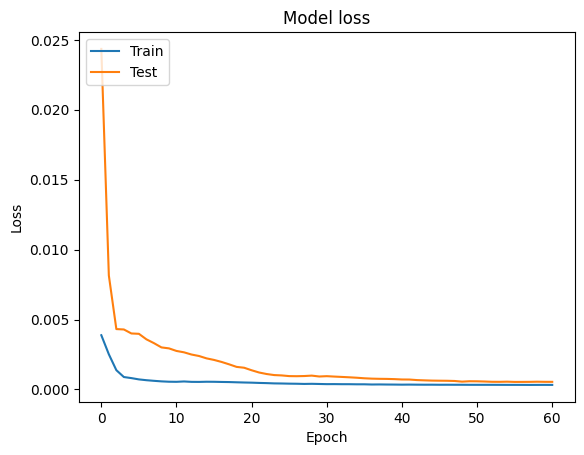

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

ValueError: Layer count mismatch when loading weights from file. Model expected 4 layers, found 2 saved layers.

MSE:  0.011650780166489625
MAE:  0.08919674500823123


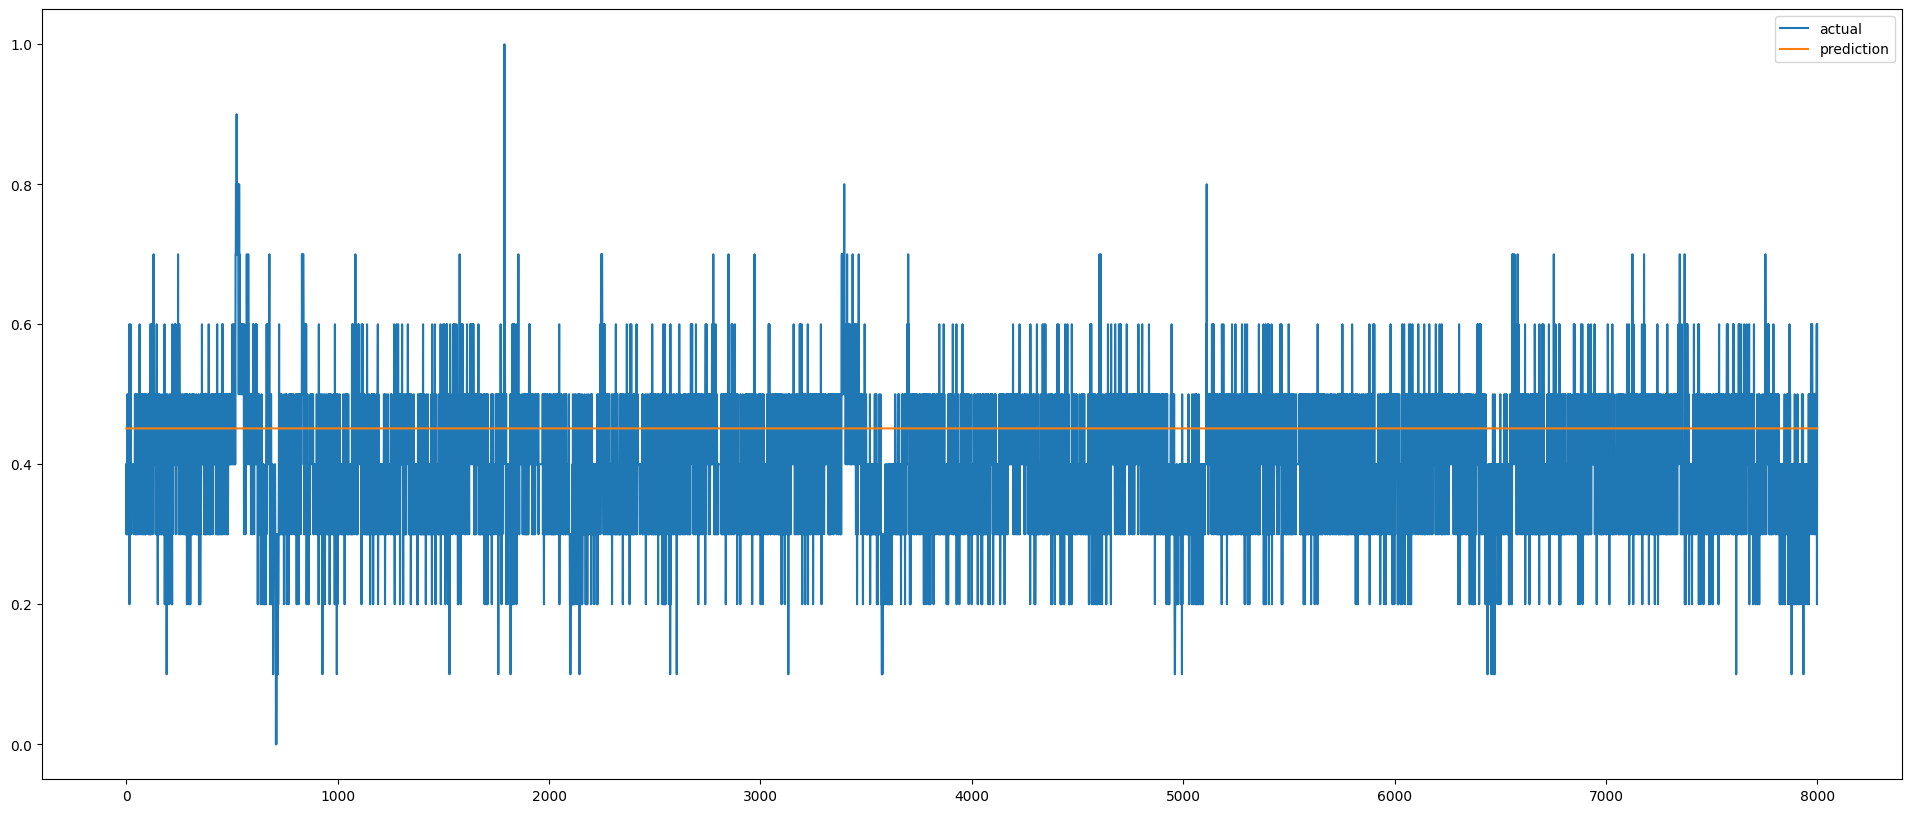

In [300]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("MSE: ", mean_squared_error(test_label.values, pred))
print("MAE: ", mean_absolute_error(test_label.values, pred))
plt.figure(figsize=(24,10))
plt.plot(test_label.values[:], label='actual')
plt.plot(pred[:], label='prediction')
plt.legend()
plt.show()

In [282]:
test_feature2

,operation_344_random,operation_362_random,operation_368_random,temperature_329_prime
72129,1,0,1,0.300412
72130,1,1,0,0.300412
72131,1,1,0,0.296296
72132,1,1,1,0.296296
72133,0,1,1,0.292181
...,...,...,...,...
80124,0,1,1,0.102881
80125,1,0,0,0.102881
80126,1,0,0,0.098765
80127,0,1,0,0.106996


MSE:  0.009340878412536554
MAE:  0.04013264695270603


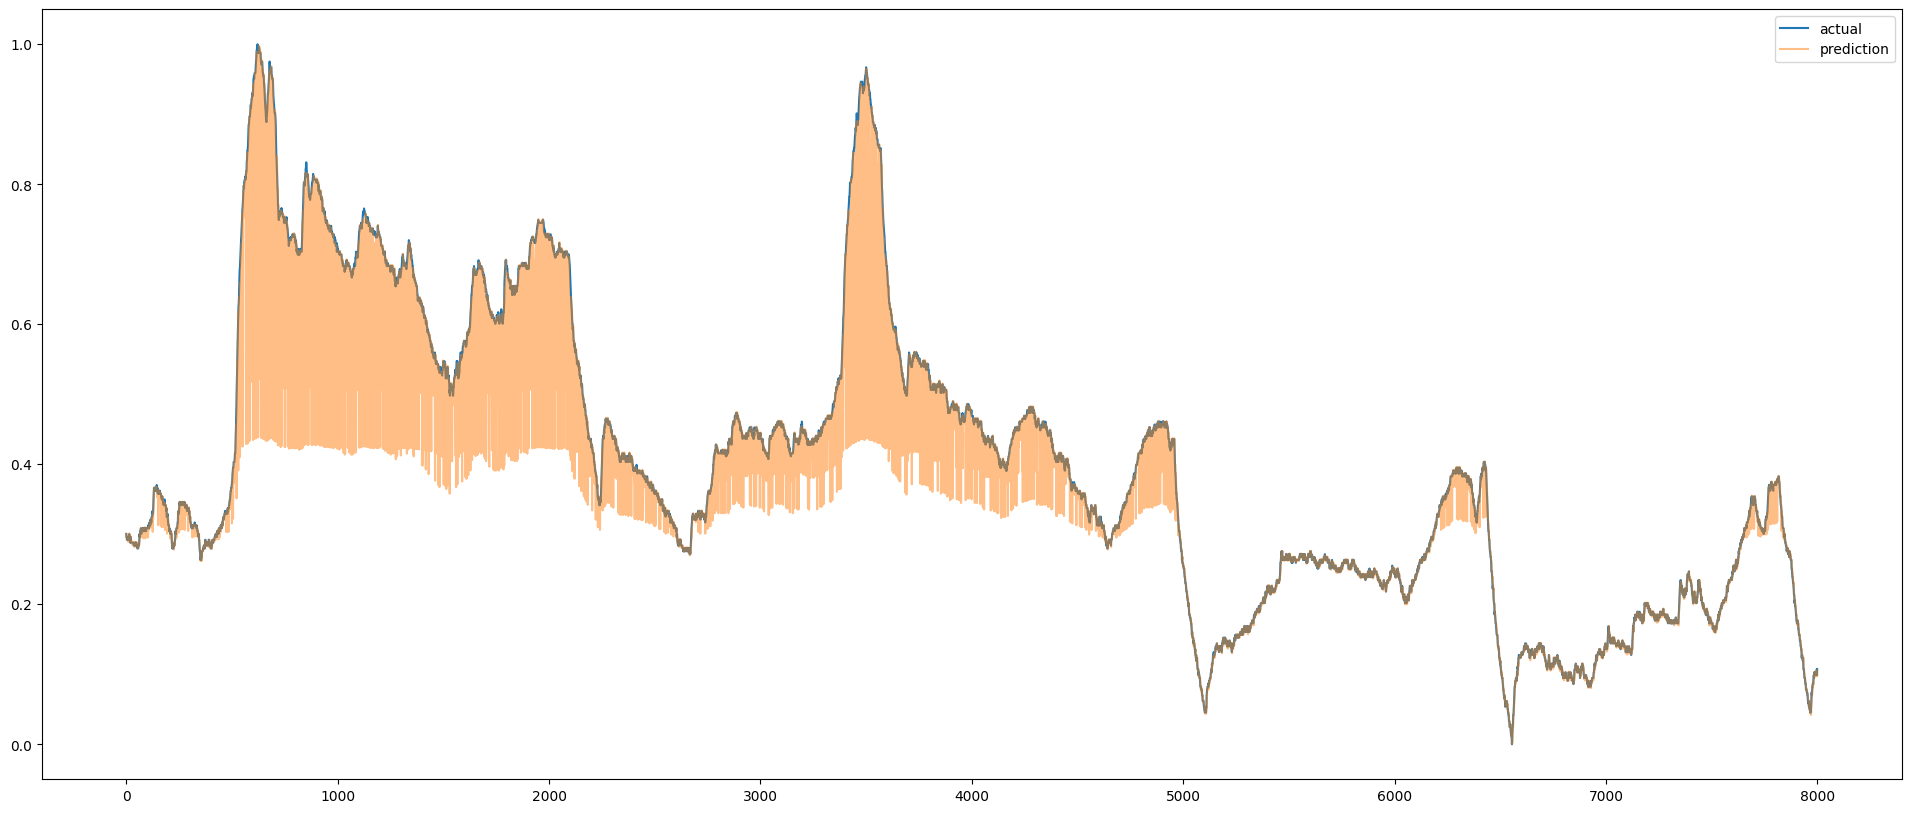

In [285]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("MSE: ", mean_squared_error(test_label.values, pred2))
print("MAE: ", mean_absolute_error(test_label.values, pred2))
plt.figure(figsize=(24,10))
plt.plot(test_label.values, label='actual')
plt.plot(pred2, label='prediction', alpha = 0.5)
plt.legend()
plt.show()

In [271]:
df

,gw_time,temperature_329,temperature_329_prime,dT_329,operation_344,operation_362,operation_368,operation_344_random,operation_362_random,operation_368_random
1,2021-02-01 00:00:34,-20.31,-20.30,-0.01,0.0,1.0,1.0,1,1,1
2,2021-02-01 00:01:04,-20.31,-20.31,0.00,0.0,1.0,1.0,1,1,1
3,2021-02-01 00:01:35,-20.31,-20.31,0.00,0.0,1.0,1.0,1,1,1
4,2021-02-01 00:02:05,-20.30,-20.31,0.01,0.0,1.0,1.0,1,1,1
5,2021-02-01 00:02:35,-20.31,-20.30,-0.01,0.0,1.0,1.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
80124,2021-02-28 23:57:33,-18.94,-18.94,0.00,1.0,1.0,1.0,1,1,1
80125,2021-02-28 23:58:03,-18.95,-18.94,-0.01,1.0,1.0,1.0,1,1,1
80126,2021-02-28 23:58:33,-18.93,-18.95,0.02,1.0,1.0,1.0,1,1,1
80127,2021-02-28 23:59:03,-18.95,-18.93,-0.02,1.0,1.0,1.0,1,1,1
